### Compare database cutoffs

Input files:<br>
Simulated custom cutoff 0.001 / 0.05 / 0.01 (pickle): metameta_$*$simulated_$*$DB.pickle<br>
The 65 sp in custom DB: 65sp.txt<br>
True assignments: metameta_$*$truth.tsv

In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import warnings
from functools import reduce
from scipy import stats
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
def calculate_missclassified(sant, forutspadd):
    """
    Calculates True postives, false negatives, # NAs and misclassifed taxa when comparing predicted taxa with the 
    groud truth. 
    """
    # percentage of misclassified examples
    if len(sant) != len(forutspadd):
        print('Ground truth and predicted are not the same length.')
        
    true_positives = 0
    missclassified_count = 0
    NA_count = 0
    false_positive = 0
    for pp, prediction in enumerate(forutspadd):
        if prediction == sant[pp]:
            true_positives += 1
        else:
            missclassified_count +=1
            if prediction == 'NA':
                NA_count +=1
            else:
                false_positive +=1

    # Percetage
    TP = true_positives / len(forutspadd) # Note: TP = accuracy
    FN = false_positive / len(forutspadd)
    NA = NA_count / len(forutspadd)
    misclassified = missclassified_count / len(forutspadd)
    
    return TP, FN, NA, misclassified

def change_order(row):
    rv_row = row.split(',')
    rv_row.reverse()
    return ','.join(rv_row) # return species level

def rm_specie(row):
    rv_row = row.split(',')
    if len(rv_row) == 7:
        return ','.join(rv_row[1:]) # return genus level
    else:
        return ','.join(rv_row) # return genus level

In [17]:
from matplotlib.text import Text
import matplotlib.pyplot as plt
from matplotlib import transforms, lines
import matplotlib.transforms as mtransforms
from matplotlib.font_manager import FontProperties
from seaborn.utils import remove_na
import statsmodels.stats.multitest as multi

from scipy import stats
DEFAULT = object()

def stat_test(box_data1, box_data2, test):
    test_short_name = ''
    formatted_output = None
    if test == 'Wilcoxon':
        u_stat, pval = stats.ranksums(box_data1, box_data2)
        test_short_name = 'Wilcox'
        formatted_output = ("Wilcoxon test P_val={:.3e} U_stat={:.3e}"
                           .format(pval, u_stat))
        
    elif test == 'ttest':
        u_stat, pval = stats.ttest_ind(box_data1, box_data2, equal_var=True)
        test_short_name = 'T-test'
        formatted_output = ("T-test P_val={:.3e} U_stat={:.3e}"
                           .format(pval, u_stat))
    return pval, u_stat,formatted_output, test_short_name


def pval_annotation_text(x, pvalue_thresholds):
    singleValue = False
    if type(x) is np.array:
        x1 = x
    else:
        x1 = np.array([x])
        singleValue = True
    # Sort the threshold array
    pvalue_thresholds = pd.DataFrame(pvalue_thresholds).sort_values(by=0, ascending=False).values
    x_annot = pd.Series(["" for _ in range(len(x1))])
    for i in range(0, len(pvalue_thresholds)):
        if (i < len(pvalue_thresholds)-1):
            condition = (x1 <= pvalue_thresholds[i][0]) & (pvalue_thresholds[i+1][0] < x1)
            x_annot[condition] = pvalue_thresholds[i][1]
        else:
            condition = x1 < pvalue_thresholds[i][0]
            x_annot[condition] = pvalue_thresholds[i][1]

    return x_annot if not singleValue else x_annot.iloc[0]


def simple_text(pval, pvalue_format, pvalue_thresholds, test_short_name=None):
    """
    Generates simple text for test name and pvalue
    :param pval: pvalue
    :param pvalue_format: format string for pvalue
    :param test_short_name: Short name of test to show
    :param pvalue_thresholds: String to display per pvalue range
    :return: simple annotation
    """
    # Sort thresholds
    thresholds = sorted(pvalue_thresholds, key=lambda x: x[0])

    # Test name if passed
    text = test_short_name and test_short_name + " " or ""

    for threshold in thresholds:
        if pval < threshold[0]:
            pval_text = "p ≤ {}".format(threshold[1])
            break
    else:
        pval_text = "p = {}".format(pvalue_format).format(pval)

    #return text + pval_text
    return pval_text


def add_stat_annotation(ax,
                        data=None, x=None, y=None, hue=None, order=None, hue_order=None,
                        box_pairs=None,
                        test='t-test_welch', text_format='star', pvalue_format_string=DEFAULT,
                        loc='inside', show_test_name=True, pvalue_thresholds=DEFAULT,
                        use_fixed_offset=False, line_offset_to_box=None, line_offset=None,
                        line_height=0.02, text_offset=1, stack=True,
                        color='0.2', linewidth=1.5, fontsize='medium', verbose=1, multi_corr = False):
    """
    User should use the same argument for the data, x, y, hue, order, hue_order as the seaborn boxplot function.
    line_height is in axes fraction coordinates.
    text_offset is in points.
    box_pairs can be of either form:
    For non-grouped boxplot: [(cat1, cat2), (cat3, cat4)]
    For boxplot grouped by hue: [((cat1, hue1), (cat2, hue2)), ((cat3, hue3), (cat4, hue4))]
    Default pvalue_format_string is "{.3e}".
    pvalue_thresholds is a list of lists or tuples. Default is:
    For "star" text_format:
        [[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], [0.05, "*"], [1, "ns"]]
    For "simple" text_format :
        [[1e-5, "1e-5"], [1e-4, "1e-4"], [1e-3, "0.001"], [1e-2, "0.01"]]
    """

    def find_x_position_box(box_plotter, boxName):
        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")
        """
        if box_plotter.plot_hues is None:
            cat = boxName
            hueOffset = 0
        else:
            cat = boxName[0]
            hue = boxName[1]
            hueOffset = box_plotter.hue_offsets[box_plotter.hue_names.index(hue)]

        groupPos = box_plotter.group_names.index(cat)
        boxPos = groupPos + hueOffset
        return boxPos


    def get_box_data(box_plotter, boxName):
        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")
        Here we really have to duplicate seaborn code, because there is not direct access to the
        box_data in the BoxPlotter class.
        """
        if box_plotter.plot_hues is None:
            cat = boxName
        else:
            cat = boxName[0]
            hue = boxName[1]

        i = box_plotter.group_names.index(cat)
        group_data = box_plotter.plot_data[i]

        if box_plotter.plot_hues is None:
            # Draw a single box or a set of boxes
            # with a single level of grouping
            box_data = remove_na(group_data)
        else:
            hue_level = hue
            hue_mask = box_plotter.plot_hues[i] == hue_level
            box_data = remove_na(group_data[hue_mask])

        return box_data

    # Set default values if necessary
    if pvalue_format_string is DEFAULT:
        pvalue_format_string = '{:.3e}'
        simple_format_string = '{:.2f}'
    else:
        simple_format_string = pvalue_format_string

    if pvalue_thresholds is DEFAULT:
        if text_format == "star":
            pvalue_thresholds = [[1e-4, "****"], [1e-3, "***"],
                                 [1e-2, "**"], [0.05, "*"], [1, "ns"]]
        else:
            pvalue_thresholds = [[1e-5, "1e-5"], [1e-4, "1e-4"],
                                 [1e-3, "0.001"], [1e-2, "0.01"]]
    
    fig = plt.gcf()

    valid_list = ['inside', 'outside']
    if loc not in valid_list:
        raise ValueError("loc value should be one of the following: {}.".format(', '.join(valid_list)))
    valid_list = ['Wilcoxon', 'ttest']
    if test not in valid_list:
        raise ValueError("test value should be one of the following: {}.".format(', '.join(valid_list)))

    if verbose >= 1 and text_format == 'star':
        print("pvalue annotation legend:")
        pvalue_thresholds = pd.DataFrame(pvalue_thresholds).sort_values(by=0, ascending=False).values
        for i in range(0, len(pvalue_thresholds)):
            if (i < len(pvalue_thresholds)-1):
                print('{}: {:.2e} < p <= {:.2e}'.format(pvalue_thresholds[i][1], pvalue_thresholds[i+1][0], pvalue_thresholds[i][0]))
            else:
                print('{}: p <= {:.2e}'.format(pvalue_thresholds[i][1], pvalue_thresholds[i][0]))
        print()

    # Create the same BoxPlotter object as seaborn's boxplot
    box_plotter = sns.categorical._BoxPlotter(x, y, hue, data, order, hue_order,
                                              orient=None, width=.8, color=None, palette=None, saturation=.75,
                                              dodge=True, fliersize=5, linewidth=None)
    #print(box_plotter.group_names, box_plotter.hue_names)
    ylim = ax.get_ylim()
    yrange = ylim[1] - ylim[0]
    #print("YRANGE: ", yrange)

    if line_offset is None:
        if loc == 'inside':
            line_offset = 0.05
            if line_offset_to_box is None:
                line_offset_to_box = 0.06 
        elif loc == 'outside':
            line_offset = 0.03
            line_offset_to_box = line_offset
    else:
        if loc == 'inside':
            if line_offset_to_box is None:
                line_offset_to_box = 0.06 
        elif loc == 'outside':
            line_offset_to_box = line_offset
    y_offset = line_offset*yrange
    y_offset_to_box = line_offset_to_box*yrange

    y_stack = []
    annList = []
    test_result_list = []
    multi_corr_list = []
    for box1, box2 in box_pairs:

        valid = None
        group_names = box_plotter.group_names
        hue_names = box_plotter.hue_names
        if box_plotter.plot_hues is None:
            cat1 = box1
            cat2 = box2
            hue1 = None
            hue2 = None
            label1 = '{}'.format(cat1)
            label2 = '{}'.format(cat2)
            valid = cat1 in group_names and cat2 in group_names
        else:
            cat1 = box1[0]
            hue1 = box1[1]
            cat2 = box2[0]
            hue2 = box2[1]
            label1 = '{}_{}'.format(cat1, hue1)
            label2 = '{}_{}'.format(cat2, hue2)
            valid = cat1 in group_names and cat2 in group_names and hue1 in hue_names and hue2 in hue_names

        if valid:
            # Get position of boxes
            x1 = find_x_position_box(box_plotter, box1)
            x2 = find_x_position_box(box_plotter, box2)
            box_data1 = get_box_data(box_plotter, box1)
            box_data2 = get_box_data(box_plotter, box2)
            ymax1 = box_data1.max()
            ymax2 = box_data2.max()

            pval, u_stat,formatted_output, test_short_name = stat_test(box_data1, box_data2, test)
            test_result_list.append({'pvalue':pval, 'test_short_name':test_short_name,
                                   'formatted_output':formatted_output, 'box1':box1, 'box2':box2})
                
            if verbose >= 1:
                print("{} v.s. {}: {}".format(label1, label2, formatted_output))

            if text_format == 'full':
                text = "{} p = {}".format('{}', pvalue_format_string).format(test_short_name, pval)
            elif text_format is None:
                text = None
            elif text_format is 'star':
                text = pval_annotation_text(pval, pvalue_thresholds)
            elif text_format is 'simple':
                test_short_name = show_test_name and test_short_name or ""
                text = simple_text(pval, simple_format_string, pvalue_thresholds,
                                   test_short_name)

            if loc == 'inside':
                yref = max(ymax1, ymax2)
            elif loc == 'outside':
                yref = ylim[1]

            if stack:
                if len(y_stack) > 0:
                    yref2 = max(yref, max(y_stack))
                else:
                    yref2 = yref
            else:
                yref2 = yref

            if len(y_stack) == 0:
                y = yref2 + y_offset_to_box
            else:
                y = yref2 + y_offset
            h = line_height*yrange
            lineX, lineY = [x1, x1, x2, x2], [y, y + h, y + h, y]
            if loc == 'inside':
                ax.plot(lineX, lineY, lw=linewidth, c=color)
            elif loc == 'outside':
                line = lines.Line2D(lineX, lineY, lw=linewidth, c=color, transform=ax.transData)
                line.set_clip_on(False)
                ax.add_line(line)

            if text is not None:
                #print('fontsize', fontsize)
                ann = ax.annotate(text, xy=(np.mean([x1, x2]), y + h),
                                  xytext=(0, text_offset), textcoords='offset points',
                                  xycoords='data', ha='center', va='bottom', fontsize=fontsize,
                                  clip_on=False, annotation_clip=False)
                annList.append(ann)

            ax.set_ylim((ylim[0], 1.1*(y + h)))

            if text is not None:
                plt.draw()
                y_top_annot = None
                got_mpl_error = False
                if not use_fixed_offset:
                    try:
                        bbox = ann.get_window_extent()
                        bbox_data = bbox.transformed(ax.transData.inverted())
                        y_top_annot = bbox_data.ymax
                    except RuntimeError:
                        got_mpl_error = True

                if use_fixed_offset or got_mpl_error:
                    if verbose >= 1:
                        print("Warning: cannot get the text bounding box. Falling back to a fixed y offset. Layout may be not optimal.")
                    # We will apply a fixed offset in points, based on the font size of the annotation.
                    fontsize_points = FontProperties(size='medium').get_size_in_points()
                    offsetTrans = mtransforms.offset_copy(ax.transData, fig=fig,
                                                          x=0, y=1.0*fontsize_points + text_offset, units='points')
                    yTopDisplay = offsetTrans.transform((0, y + h))
                    y_top_annot = ax.transData.inverted().transform(yTopDisplay)[1]
            else:
                y_top_annot = y + h

            y_stack.append(y_top_annot)
        else:
            raise ValueError("box_pairs contains an unvalid box pair.")
            pass

    y_stack_max = max(y_stack)
    if loc == 'inside':
        ax.set_ylim((ylim[0], 1.03*y_stack_max))
    elif loc == 'outside':
        ax.set_ylim((ylim[0], ylim[1]))
    
    if multi_corr == True:
        corrected_pvals = multiple_correction(multi_corr_list)
        
        for i, corr_p in enumerate(corrected_pvals):
            test_result_list[i]['Corrected pvalue'] = corr_p
            
        
    #print(test_result_list, ax)

    return ax, test_result_list


# Load simulated data set run in bac_pipe

In [8]:
# Load pickle file
info_d = {}
fastq_spot_d = {}

path = ''

for file in os.listdir(path):
    if file.endswith(".pickle"):
        name = file.split('.')[0]

        with open(os.path.join(path, file), 'rb') as handle:
            b = pickle.load(handle)

        info = pd.DataFrame.from_dict(b, orient='index')

        info['taxa_order'] = info.apply(lambda row: change_order(row['taxa_order']), axis=1)
        info['taxa_order'] = info.apply(lambda row: rm_specie(row['taxa_order']), axis=1)
        
        #include some additional naming which make the result look worse than what it actually is
        info['taxa_order'] = info['taxa_order'].str.replace('"','')
        info['taxa_order'] = info['taxa_order'].str.replace(' IV', '')
        info['taxa_order'] = info['taxa_order'].str.replace(' sensu stricto', '')
        info['taxa_order'] = info['taxa_order'].str.replace(' 1', '')
        
        info_d[name] = info
        
        # For truth - get fastq headers per spot
        tmp_d = {}

        for label, group in info.groupby(['x', 'y']):
            spot = label[0].split(':')[-1] + 'x' + label[1].split(':')[-1]
            tmp_d[spot] = group['fastq'].tolist()
            
        fastq_spot_d[name] = tmp_d


# Evaluation

In [11]:
# Only evaluate on overlapping species
overlap_path = ''
overlap_file = '65sp.txt' 

with open(os.path.join(overlap_path, overlap_file)) as file:
    overlapsp = [line.rstrip() for line in file]

# Current assignments
truth_path = ''
tx_rv = ["Species", "Genus", "Family", "Order", "Class", "Phylum", "Doamin"]
truth_d = {}
for file in os.listdir(truth_path):
    if file.endswith("truth.tsv"):
        name = file.split('_truth')[0]
    
        truth = pd.read_csv(os.path.join(truth_path, file))

        truth[tx_rv] = truth["full taxa"].str.split(pat=",", expand=True)

        # Remove Nan in full taxa
        truth.dropna(subset=['full taxa'], inplace=True)
        
        # Subset based on overlapping species
        truth = truth[truth['Species'].isin(overlapsp)]
    
        truth_d[name] = truth
              

In [12]:
#### Stats ####

taxa_orders = ["Doamin", "Phylum", "Class", "Order", "Family", "Genus", "Species"]

n = ['metameta_1', 
     'metameta_2', 
     'metameta_3']
db_to_test = ['01DB', '005DB', '001DB']

stats_D = {}

count = 0

for ni in n:
    
    stats_d = {}
    
    db1 = '_'.join([ni, 'simulated', db_to_test[0]])
    db2 = '_'.join([ni, 'simulated', db_to_test[1]])
    db3 = '_'.join([ni, 'simulated', db_to_test[2]])
    
    # Collect spots in samples
    info_coordXY = info_d[db1].loc[:,['x','y']]
    info_coordXY.drop_duplicates(inplace=True)
    info_coordXY['tuple'] = list(zip(info_coordXY['x'], info_coordXY['y']))

    for tup in info_coordXY['tuple'].tolist(): # go through each spot
        spot_coord = tup[0].split(':')[-1] + 'x' + tup[1].split(':')[-1]        
        
        ### Truth assignments
        truth_spot = truth_d[ni][truth_d[ni]['index'].isin(fastq_spot_d[db1][spot_coord])]
        truth_spot_index = truth_spot['index']
        
        ### DB1: Predicted assignments by Kraken2
        db1kraken = info_d[db1][(info_d[db1]['x'] == tup[0]) & (info_d[db1]['y'] == tup[1]) &
                               (info_d[db1]['fastq'].isin(truth_spot_index))]
        
        db1kraken[tx_rv[1:]] = db1kraken["taxa_order"].str.split(pat=",", expand=True)

        ### DB2: Predicted assignments by Kraken2
        db2kraken = info_d[db2][(info_d[db2]['x'] == tup[0]) & (info_d[db2]['y'] == tup[1]) &
                               (info_d[db2]['fastq'].isin(truth_spot_index))]
        db2kraken[tx_rv[1:]] = db2kraken["taxa_order"].str.split(pat=",", expand=True)
        
        ### DB3: Predicted assignments by Kraken2
        db3kraken = info_d[db3][(info_d[db3]['x'] == tup[0]) & (info_d[db3]['y'] == tup[1]) &
                               (info_d[db3]['fastq'].isin(truth_spot_index))]
        db3kraken[tx_rv[1:]] = db3kraken["taxa_order"].str.split(pat=",", expand=True)
        
        if truth_spot.shape[0] > 0:
            count += 1
            for level in taxa_orders[1:-1]:
                tru = truth_spot.groupby(level).count()['full taxa']
                db1krak = db1kraken.groupby(level).count()['taxa_order']
                db2krak = db2kraken.groupby(level).count()['taxa_order']
                db3krak = db3kraken.groupby(level).count()['taxa_order']
                
                ##### STATS #####  
                tru = truth_spot[['index', level]]
                db1krak = db1kraken[['fastq', level]]
                db2krak = db2kraken[['fastq', level]]
                db3krak = db3kraken[['fastq', level]]
                tru.rename(columns={'index':'fastq'}, inplace=True)
                
                mer = reduce(lambda x,y: pd.merge(x,y, on='fastq', how='outer'), [db1krak, db2krak, db3krak, tru])            
                
                mer.columns = ['fastq', level + '_x', level + '_y', level + '_z', level]

               # Calculate stats (unweighted)
                stattmp = {}

                # DB1
                stats_tru_pred = classification_report(mer[level].tolist(), mer[level + '_x'].tolist(), 
                                              labels=list(set(mer[level].tolist())), 
                                              target_names=list(set(mer[level].tolist())), 
                                              sample_weight=None, digits=2, 
                                              output_dict=True, 
                                              zero_division='warn')
                # DB2
                stats_tru_krak = classification_report(mer[level].tolist(), mer[level + '_y'].tolist(), 
                                              labels=list(set(mer[level].tolist())), 
                                              target_names=list(set(mer[level].tolist())), 
                                              sample_weight=None, digits=2, 
                                              output_dict=True, 
                                              zero_division='warn')
                
                # DB3
                stats_tru_3 = classification_report(mer[level].tolist(), mer[level + '_z'].tolist(), 
                                              labels=list(set(mer[level].tolist())), 
                                              target_names=list(set(mer[level].tolist())), 
                                              sample_weight=None, digits=2, 
                                              output_dict=True, 
                                              zero_division='warn')
                

                TP_pred, FN_pred, NA_pred, misclassified_pred = calculate_missclassified(mer[level + '_x'].tolist(), mer[level].tolist()) #DB1
                TP_krak, FN_krak, NA_krak, misclassified_krak = calculate_missclassified(mer[level + '_y'].tolist(), mer[level].tolist()) #DB2
                TP_3, FN_3, NA_3, misclassified_3 = calculate_missclassified(mer[level + '_z'].tolist(), mer[level].tolist()) #DB3               
                
                # DB1
                try: 
                    stp = stats_tru_pred['accuracy']
                except KeyError:
                    stp = stats_tru_pred['micro avg']['recall']
                # DB2
                try: 
                    stk = stats_tru_krak['accuracy']
                except KeyError:
                    stk = stats_tru_krak['micro avg']['recall']
                # DB3
                try: 
                    st3 = stats_tru_3['accuracy']
                except KeyError:
                    st3 = stats_tru_3['micro avg']['recall']
                
                
                data_tuples = list(zip([level, db_to_test[0], stp, stats_tru_pred['macro avg']['f1-score'], FN_pred, NA_pred, misclassified_pred],
                                      [level, db_to_test[1], stk, stats_tru_krak['macro avg']['f1-score'], FN_krak, NA_krak, misclassified_krak],
                                          [level, db_to_test[2], st3, stats_tru_3['macro avg']['f1-score'], FN_3, NA_3, misclassified_3]))

                df_stats = pd.DataFrame(data_tuples, index = ['taxa order', 'type','accuracy', 'F1-score', 'False Pos', 'NAs', 'Misclassified']).T

                stattmp[level] = df_stats

                if not spot_coord in stats_d:
                    stats_d[spot_coord] = stattmp
                else:
                    stats_d[spot_coord][level] = df_stats 
    stats_D[ni] = stats_d


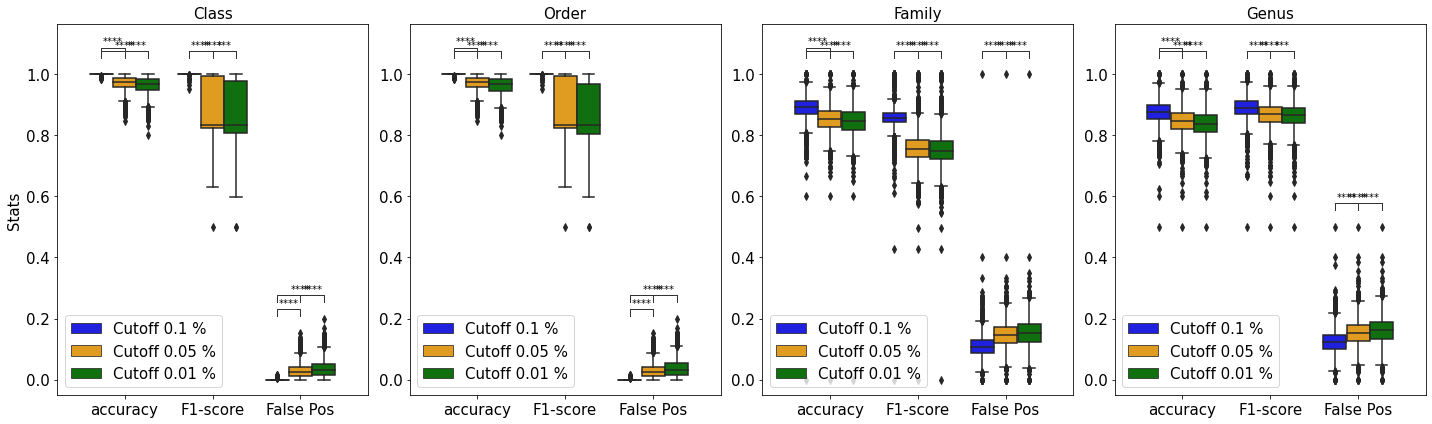

In [18]:
# Average stats_d
l = []

for jk, stats_d in stats_D.items():
    for k,v in stats_d.items():
        for ik, iv in v.items():
            iv['name'] = jk
            l.append(iv)
    
l2 = pd.concat(l)
l2[['accuracy', 'F1-score', 'False Pos']] = l2[['accuracy', 'F1-score', 'False Pos']].apply(pd.to_numeric)
    
fig = plt.figure(figsize=(20,6))

# for a 2x3 subplot
axes = []
for row_idx in range(0,1):
    for col_idx in range(0,4):
        ax = plt.subplot2grid((1, 4), (row_idx, col_idx))
        axes.append(ax)

x = 'variable'
y = 'value'
hue = 'type'

colors = {'01DB':'blue',
         '005DB':'orange',
         '001DB':'green'}
order = ['01DB', '005DB', '001DB']
    
for i, tx in enumerate(taxa_orders[2:6]):
    l5 = l2[l2['taxa order'] == tx]
    
    # To get mean value
    l3 = l5.groupby(['name', 'type']).mean().reset_index()
    l3 = pd.melt(l3, id_vars=['type'], value_vars=['accuracy', 'F1-score', 'False Pos'])
    
    l4 = pd.melt(l5, id_vars=['type'], value_vars=['accuracy', 'F1-score', 'False Pos'])
    
    ax = axes[i]
    
    sns.boxplot(x=x, y=y, hue=hue, data=l4, ax=ax, palette=colors, hue_order=order)
    ax.set_title(tx, fontsize=15)
    ax.set_xlabel("")
    ax.tick_params(axis='both', which='major', labelsize=15)
    
    if i == 0:
        ax.set_ylabel("Stats", fontsize=15)
    else:
        ax.set_ylabel("")
    
    # Legend
    handles, labels = ax.get_legend_handles_labels()
    labels[0] = 'Cutoff 0.1 %'
    labels[1] = 'Cutoff 0.05 %'
    labels[2] = 'Cutoff 0.01 %'
    ax.legend(handles[0:3], labels[0:3], fontsize=15, loc='lower left')
    
    # Add t test    
    boxPairList = [(('accuracy', '01DB'), ('accuracy','005DB')),
                    (('F1-score', '01DB'), ('F1-score', '005DB')),
               (('False Pos', '01DB'), ('False Pos', '005DB')),
                  (('accuracy', '005DB'), ('accuracy','001DB')),
                    (('F1-score', '005DB'), ('F1-score', '001DB')),
               (('False Pos', '005DB'), ('False Pos', '001DB')),
                  (('accuracy', '01DB'), ('accuracy','001DB')),
                    (('F1-score', '01DB'), ('F1-score', '001DB')),
               (('False Pos', '01DB'), ('False Pos', '001DB'))]

    add_stat_annotation(ax, data=l4, x=x, y=y, hue=hue,
                    box_pairs=boxPairList,
                    test='ttest', text_format='star', loc='inside', verbose=0, linewidth=1, stack=False, fontsize=10)
 
plt.tight_layout() 
